### This exercise is part of an online competion on Kaggle for creating an algorithm that predicts if a test sample went missing in a Space Titanic accident, in an event horizon style stituation

### Like always, first we load the libraries, since I tried a lot of strategies, this is a long list:

In [546]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import  Dense, Dropout

### We load the data provided in the exercise:

In [547]:
train_url = "https://raw.githubusercontent.com/Herrikez/Machine-Learning/main/train.csv"
test_url = "https://raw.githubusercontent.com/Herrikez/Machine-Learning/main/test.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### We examine te data and then examine some more, to try to get some insights:

In [548]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### We look for missing values:

In [549]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [550]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

### Yeah that's going to take some time, and since the test sample also has missing values that we need to predict for the competion, we cannot just remove the incomplete values from the training data, both groups have to go throught the same preprocessing to maximize the accuracy.

In [551]:
train[train.isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,Chain Reedectied,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True


### It seems like the cabin and the passengerID columns holds some information, let's split it into its constituents, and do the same with the names, who knows

In [552]:
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)
test[["ID1", "ID2"]] = test['PassengerId'].str.split('_', expand=True).astype(float)
test[["1stName", "Surname"]] = test['Name'].str.split(' ', expand=True).astype(str)
test[["Num"]] = test[["Num"]].astype(float)

test = test.drop(['PassengerId', "Cabin", "Name"], axis=1, errors='ignore')


train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
train[["ID1", "ID2"]] = train['PassengerId'].str.split('_', expand=True).astype(float)
train[["1stName", "Surname"]] = train['Name'].str.split(' ', expand=True).astype(str)
train[["Num"]] = train[["Num"]].astype(float)
                                      
train = train.drop(['PassengerId', "Cabin", "Name"], axis=1, errors='ignore')
train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1.0,1.0,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,2.0,1.0,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,3.0,1.0,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,3.0,2.0,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,4.0,1.0,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98.0,P,9276.0,1.0,Gravior,Noxnuther
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499.0,S,9278.0,1.0,Kurta,Mondalley
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500.0,S,9279.0,1.0,Fayey,Connon
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608.0,S,9280.0,1.0,Celeon,Hontichre


### Looking at the where the VIPs stay, it seems that they don't like Deck G, maybe it is not fancy enought, the Deck T seems to be the tribulation deck with just 5 people, very few, but maybe in the future most jobs are fully automatized:

In [553]:
train.groupby("Deck")["VIP"].value_counts()

Deck  VIP  
A     False     215
      True       35
B     False     725
      True       42
C     False     687
      True       41
D     False     438
      True       31
E     False     846
      True       15
F     False    2695
      True       29
G     False    2493
T     False       5
Name: count, dtype: int64

### Let's use that information to get rid of some null values, if you are VIP I assume that you are not travelling on Deck G or T and if you are of Deck G or T I assume that your are not a VIP:

In [554]:
test.loc[(test['Deck'] == "G") & (test['VIP'].isna()),'VIP'] = False
test.loc[(test['Deck'] == "T") & (test['VIP'].isna()),'VIP'] = False

train.loc[(train['Deck'] == "G") & (train['VIP'].isna()),'VIP'] = False
train.loc[(train['Deck'] == "T") & (train['VIP'].isna()),'VIP'] = False

### Let's see if there is a connection between Deck and HomePlanet:

In [555]:
train.groupby("Deck")["HomePlanet"].value_counts()

Deck  HomePlanet
A     Europa         252
B     Europa         766
C     Europa         734
D     Mars           282
      Europa         186
E     Earth          395
      Mars           330
      Europa         128
F     Earth         1614
      Mars          1110
G     Earth         2498
T     Europa           4
Name: count, dtype: int64

In [556]:
train.groupby("HomePlanet")["Deck"].value_counts()

HomePlanet  Deck
Earth       G       2498
            F       1614
            E        395
Europa      B        766
            C        734
            A        252
            D        186
            E        128
            T          4
Mars        F       1110
            E        330
            D        282
Name: count, dtype: int64

### There is! Let's use this information to decrease the number of null values:

In [557]:
test.loc[(test['Deck'] == "A") & (test['HomePlanet'].isna()),'HomePlanet'] = "Europa"
test.loc[(test['Deck'] == "B") & (test['HomePlanet'].isna()),'HomePlanet'] = "Europa"
test.loc[(test['Deck'] == "C") & (test['HomePlanet'].isna()),'HomePlanet'] = "Europa"
test.loc[(test['Deck'] == "G") & (test['HomePlanet'].isna()),'HomePlanet'] = "Earth"
test.loc[(test['Deck'] == "T") & (test['HomePlanet'].isna()),'HomePlanet'] = "Europa"

train.loc[(train['Deck'] == "A") & (train['HomePlanet'].isna()),'HomePlanet'] = "Europa"
train.loc[(train['Deck'] == "B") & (train['HomePlanet'].isna()),'HomePlanet'] = "Europa"
train.loc[(train['Deck'] == "C") & (train['HomePlanet'].isna()),'HomePlanet'] = "Europa"
train.loc[(train['Deck'] == "G") & (train['HomePlanet'].isna()),'HomePlanet'] = "Earth"
train.loc[(train['Deck'] == "T") & (train['HomePlanet'].isna()),'HomePlanet'] = "Europa"

train.isna().sum()

HomePlanet      109
CryoSleep       217
Destination     182
Age             179
VIP             137
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

### Number o null values missing from HomePlanet reduced by half, great success!

### People in Cryosleep probably didn't spend too much time on services, for obvious reasons:

In [558]:
train.groupby("CryoSleep").sum()

#as expectes

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
CryoSleep,,,,,,,,,,,,,,,,,
False,EuropaEarthEuropaEuropaEarthEarthEarthEarthEur...,TRAPPIST-1eTRAPPIST-1eTRAPPIST-1eTRAPPIST-1eTR...,158427.0,175,1865582.0,3799600.0,1443579.0,2588931.0,2530810.0,1789,BFAAFFFFBFGFFFGFEEDFCFGFFFDFFBFEEGFAAFFGGFEFFF...,3275973.0,PSSSSPSSPPSPPPPPSSPSPPSPPPPSSPPSSSSSSSSPSSSSPP...,25242681.0,7976.0,MahamJuannaAltarkSolamWillySandieBillexAndonaW...,OfracculyVinesSusentSusentSantantinesHinetthew...
True,EarthEuropaEuropaMarsEarthEarthEarthEarthEurop...,TRAPPIST-1e55 Cancri eTRAPPIST-1eTRAPPIST-1eTR...,80983.0,21,0.0,0.0,0.0,0.0,0.0,2483,GBBFEEEECDGGGGGFAGFEGGFCEGGGGGGGBEAFFGFGCGGGGB...,1696107.0,SPPPSSSSSSPPPPPPSSSSSSPSSSSPPSSSPSPPSSSPSPSSPP...,13995415.0,4886.0,CandraErraiamAltardrAlusAlmaryGlendyMollenMael...,JacostaffeyFlaticFlaticUpeadBrantuarezBrantuar...


### As expected. Let's use that information:

In [559]:
test.loc[(train['CryoSleep'] == True) & (test['Spa'].isna()),'Spa'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['VRDeck'].isna()),'VRDeck'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['FoodCourt'].isna()),'FoodCourt'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['RoomService'].isna()),'RoomService'] = 0.0

train.loc[(train['CryoSleep'] == True) & (train['Spa'].isna()),'Spa'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['VRDeck'].isna()),'VRDeck'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['FoodCourt'].isna()),'FoodCourt'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['RoomService'].isna()),'RoomService'] = 0.0

train.isna().sum()

#number of null values in each category reduced by half again

HomePlanet      109
CryoSleep       217
Destination     182
Age             179
VIP             137
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

### The opposite is also true, if you were going around using services, it's safe to say that you were not on cryosleep:

In [560]:

test.loc[(train['Spa'] > 0) & (test['CryoSleep'].isna()),'CryoSleep'] = False
test.loc[(train['VRDeck'] > 0) & (test['CryoSleep'].isna()),'CryoSleep'] = False
test.loc[(train['ShoppingMall'] > 0) & (test['CryoSleep'].isna()),'CryoSleep'] = False
test.loc[(train['FoodCourt'] > 0 ) & (test['CryoSleep'].isna()),'CryoSleep'] = False
test.loc[(train['RoomService'] > 0 ) & (test['CryoSleep'].isna()),'CryoSleep'] = False

train.loc[(train['Spa'] > 0) & (train['CryoSleep'].isna()),'CryoSleep'] = False
train.loc[(train['VRDeck'] > 0) & (train['CryoSleep'].isna()),'CryoSleep'] = False
train.loc[(train['ShoppingMall'] > 0) & (train['CryoSleep'].isna()),'CryoSleep'] = False
train.loc[(train['FoodCourt'] > 0 ) & (train['CryoSleep'].isna()),'CryoSleep'] = False
train.loc[(train['RoomService'] > 0 ) & (train['CryoSleep'].isna()),'CryoSleep'] = False

train.isna().sum()

#another batch of null values cut in half

HomePlanet      109
CryoSleep        98
Destination     182
Age             179
VIP             137
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

### Another question, Did the kids payed for their own stuff, or is it in their parents bills?

In [561]:
#Did the kids payed for their stuff, or is it in their parents bills?

train.loc[(train['RoomService'] != 0 ) &
          (train['FoodCourt'] != 0 ) &
          (train['ShoppingMall'] != 0 ) &
          (train['Spa'] != 0 ) &
          (train['VRDeck'] != 0 ) &
          (train['Age'] < 15)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
1145,Earth,False,55 Cancri e,13.0,False,1.0,212.0,843.0,78.0,10.0,True,F,232.0,S,1211.0,5.0,Scotty,Alvasquez
1271,Earth,False,TRAPPIST-1e,14.0,False,1489.0,2.0,126.0,460.0,72.0,False,F,261.0,S,1350.0,2.0,Isa,Cleang
2013,Earth,False,TRAPPIST-1e,13.0,False,579.0,226.0,61.0,1.0,7.0,False,F,420.0,S,2148.0,1.0,Ellana,Grahangory
3827,Earth,False,55 Cancri e,14.0,False,834.0,1080.0,3.0,183.0,208.0,False,G,671.0,P,4095.0,1.0,Deaney,Romez
4362,Earth,False,55 Cancri e,13.0,False,8.0,1385.0,1445.0,250.0,8.0,True,F,872.0,S,4644.0,1.0,Juliey,Fultz
6912,Earth,False,TRAPPIST-1e,14.0,False,399.0,22.0,458.0,506.0,187.0,False,F,1410.0,S,7328.0,1.0,Agnesa,Cainghannon
8492,Europa,False,TRAPPIST-1e,13.0,False,24.0,838.0,1069.0,1376.0,181.0,False,A,107.0,S,9073.0,1.0,Marazha,Shricatory


### Seems that no kid under the age of 13 paid for their stuff, the same is probably true for the missing values:


In [562]:
test.loc[(train['Age'] < 13) & (test['FoodCourt'].isna()),'FoodCourt'] = 0.0
test.loc[(train['Age'] < 13) & (test['RoomService'].isna()),'RoomService'] = 0.0
test.loc[(train['Age'] < 13) & (test['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
test.loc[(train['Age'] < 13) & (test['Spa'].isna()),'Spa'] = 0.0
test.loc[(train['Age'] < 13) & (test['VRDeck'].isna()),'VRDeck'] = 0.0

train.loc[(train['Age'] < 13) & (train['FoodCourt'].isna()),'FoodCourt'] = 0.0
train.loc[(train['Age'] < 13) & (train['RoomService'].isna()),'RoomService'] = 0.0
train.loc[(train['Age'] < 13) & (train['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
train.loc[(train['Age'] < 13) & (train['Spa'].isna()),'Spa'] = 0.0
train.loc[(train['Age'] < 13) & (train['VRDeck'].isna()),'VRDeck'] = 0.0

train.isna().sum()

#not a very large effect, seems like there were not that many kids

HomePlanet      109
CryoSleep        98
Destination     182
Age             179
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    103
Spa             114
VRDeck          107
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

### How many missing values still?

In [563]:
train[train.isna().any(axis=1)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
15,Earth,False,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,False,NaN,NaN,NaN,12.0,1.0,Justie,Pooles
16,Mars,False,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,False,F,3.0,P,14.0,1.0,Flats,Eccle
35,Mars,False,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,True,F,9.0,P,31.0,3.0,Dontch,Datie
38,Earth,False,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0,False,F,8.0,S,36.0,1.0,Marina,Leodger
47,Mars,True,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,True,F,10.0,P,45.0,2.0,Mass,Chmad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664,Earth,NaN,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,True,G,1490.0,S,9246.0,1.0,nan,nan
8666,NaN,False,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,True,F,1792.0,S,9248.0,1.0,Gian,Perle
8667,Europa,False,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,True,E,597.0,P,9250.0,1.0,Chain,Reedectied
8674,NaN,False,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,False,F,1892.0,P,9257.0,1.0,Ties,Apple


### Since deck T seems to be the tripulation, let's see if there is a pattern there:

In [564]:
train[train["Deck"] == "T"]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
1004,Europa,False,TRAPPIST-1e,35.0,False,415.0,1328.0,0.0,14.0,60.0,False,T,0.0,P,1071.0,1.0,Alraida,Dingauge
2254,Europa,False,TRAPPIST-1e,42.0,False,0.0,1829.0,2.0,3133.0,2447.0,False,T,1.0,P,2414.0,1.0,Mergak,Headfair
2734,Europa,False,TRAPPIST-1e,33.0,False,0.0,28.0,0.0,6841.0,543.0,False,T,2.0,P,2935.0,1.0,nan,nan
2763,Europa,False,TRAPPIST-1e,38.0,False,0.0,3135.0,0.0,26.0,3.0,True,T,3.0,P,2971.0,1.0,Pent,Sessiouse
4565,Europa,False,TRAPPIST-1e,37.0,False,1721.0,667.0,NaN,28.0,1362.0,False,T,2.0,S,4863.0,1.0,Phacton,Unsible


### They seem to be from the same planet, going to the destination, but not much more useful information than that.

### Now let's look at the surnames, any patterns there?

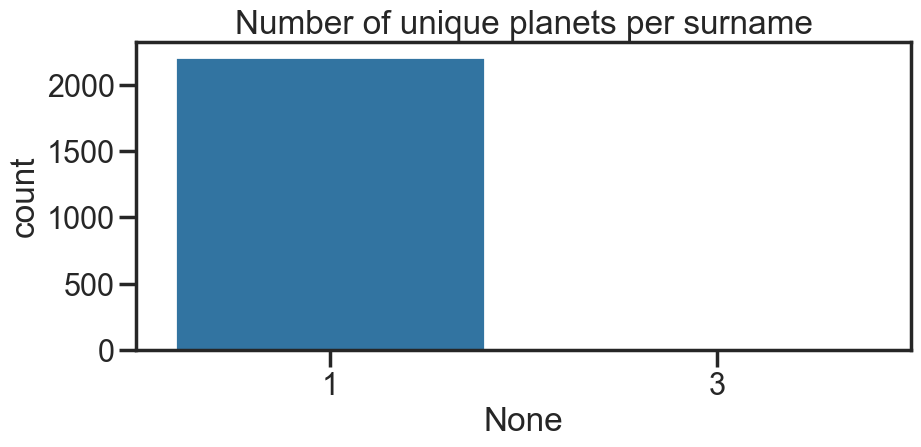

In [565]:
sns.set_context("poster")
sns.set_style("ticks")

SHP_gb = train.groupby(['Surname', 'HomePlanet']).size().unstack().fillna(0)

unique_planets_per_surname = (SHP_gb > 0).sum(axis=1)

plt.figure(figsize=(10, 4))
sns.countplot(x=unique_planets_per_surname)
plt.title('Number of unique planets per surname')
plt.show()

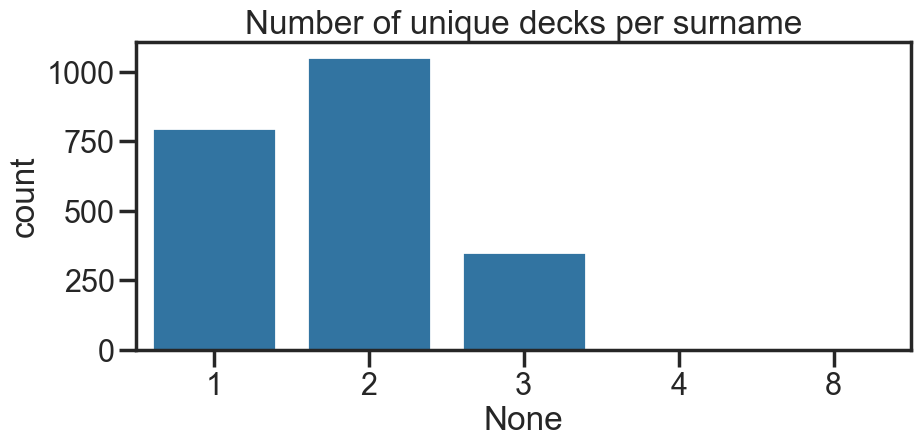

In [566]:
sns.set_context("poster")
sns.set_style("ticks")

SHP_gb = train.groupby(['Surname', 'Deck']).size().unstack().fillna(0)

unique_decks_per_surname = (SHP_gb > 0).sum(axis=1)

plt.figure(figsize=(10, 4))
sns.countplot(x=unique_decks_per_surname)
plt.title('Number of unique decks per surname')
plt.show()

### Weirdly, it seems that people with same surname overwhelmingly originate from the same planet, but are not necessarily in the same deck

In [567]:
train.loc[(train['HomePlanet'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
59,NaN,True,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,True,E,3.0,S,64.0,2.0,Colatz,Keen
186,NaN,True,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,True,D,6.0,P,210.0,1.0,Arraid,Inicont
225,NaN,False,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,False,F,46.0,S,242.0,1.0,Almone,Sté
291,NaN,False,TRAPPIST-1e,59.0,True,1018.0,0.0,209.0,0.0,0.0,False,F,61.0,S,321.0,1.0,Quites,Bache
365,NaN,True,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,True,D,15.0,S,402.0,1.0,Teron,Sageng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8489,NaN,True,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,True,F,1758.0,S,9072.0,1.0,Gork,Creke
8515,NaN,False,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,False,E,582.0,P,9084.0,1.0,Jurs,Mone
8613,NaN,False,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,False,E,603.0,S,9194.0,1.0,nan,nan
8666,NaN,False,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,True,F,1792.0,S,9248.0,1.0,Gian,Perle


### So this information is more tricky to use, I'll need to create a dictionary with the surnames and corresponding planets of origin, so that I can use to replace missing values later

In [568]:
dit = train.loc[(train['HomePlanet'].notna()) & (train['Surname'] != "nan")]
dit2 = test.loc[(test['HomePlanet'].notna()) & (test['Surname'] != "nan")]
dit = pd.concat([dit, dit2])
dit.loc[(dit['HomePlanet'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname


In [569]:
dit = dict(zip(dit["Surname"], dit["HomePlanet"]), columns = ['Surname', 'Home'])
dit

{'Ofracculy': 'Europa',
 'Vines': 'Earth',
 'Susent': 'Europa',
 'Santantines': 'Earth',
 'Hinetthews': 'Earth',
 'Jacostaffey': 'Earth',
 'Beston': 'Earth',
 'Flatic': 'Europa',
 'Barne': 'Mars',
 'Baketton': 'Earth',
 'Bertsontry': 'Earth',
 'Pooles': 'Earth',
 'Eccle': 'Mars',
 'Hughriend': 'Earth',
 'Upead': 'Mars',
 'Brighttt': 'Earth',
 'Brantuarez': 'Earth',
 'Mcfaddennon': 'Earth',
 'Jacostanley': 'Earth',
 'Fullided': 'Europa',
 'Brookenson': 'Earth',
 'Unconary': 'Europa',
 'Mare': 'Mars',
 'Morsentley': 'Earth',
 'Datie': 'Mars',
 'Oingwhedly': 'Europa',
 'Butte': 'Mars',
 'Leodger': 'Earth',
 'Wheelez': 'Earth',
 'Batthewitt': 'Earth',
 'Moodsey': 'Earth',
 'Cylistrand': 'Europa',
 'Coopelandez': 'Earth',
 'Chmad': 'Mars',
 'Lancis': 'Earth',
 'Johnshines': 'Earth',
 'Hubbarton': 'Earth',
 'Hickerson': 'Earth',
 'Tractive': 'Europa',
 'Ayalazquez': 'Earth',
 'Salez': 'Earth',
 'Greeves': 'Earth',
 'Pecketton': 'Earth',
 'Leeves': 'Earth',
 'Binie': 'Mars',
 'Dillines': 'Ear

### Using that dictionary to discover HomePlanets leaves us only with 3 missing origins:

In [570]:
train["HomePlanet"] = train["Surname"].map(dit).fillna(train['HomePlanet'])
test["HomePlanet"] = test["Surname"].map(dit).fillna(test['HomePlanet'])
test.loc[(train['HomePlanet'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,ID1,ID2,1stName,Surname
2274,Europa,False,55 Cancri e,25.0,False,0.0,1255.0,0.0,5229.0,3152.0,C,154.0,P,4949.0,2.0,Kumak,Amincrerus
2631,Earth,False,PSO J318.5-22,NaN,False,0.0,0.0,9.0,21.0,505.0,G,939.0,S,5782.0,1.0,Adanne,Fisherry
3091,Earth,False,TRAPPIST-1e,50.0,False,166.0,0.0,514.0,114.0,0.0,F,1406.0,P,6772.0,2.0,nan,nan


### There is a connection between surnames and HomePlanet, does that hold for the destination? The answer is no:

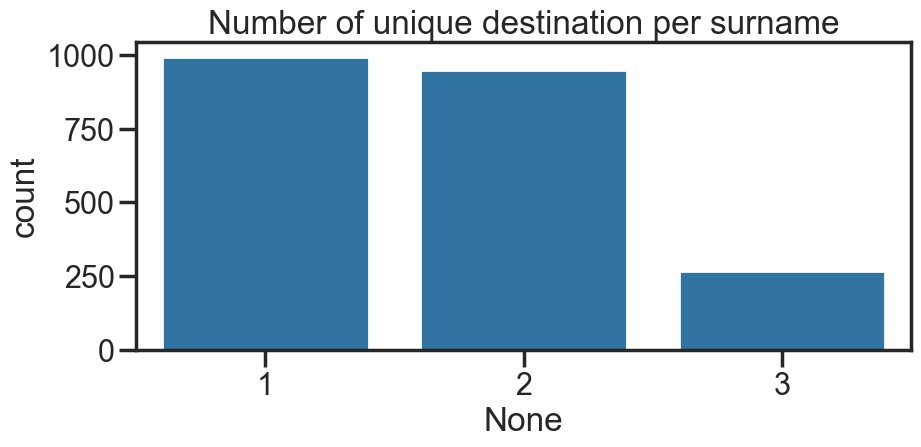

In [571]:
sns.set_context("poster")
sns.set_style("ticks")

SHP_gb = train.groupby(['Surname', 'Destination']).size().unstack().fillna(0)

unique_destination_per_surname = (SHP_gb > 0).sum(axis=1)

plt.figure(figsize=(10, 4))
sns.countplot(x=unique_destination_per_surname)
plt.title('Number of unique destination per surname')
plt.show()

### Now that we runout of clear patterns, we'll to start doing some bold assumptions to get rid of those null values

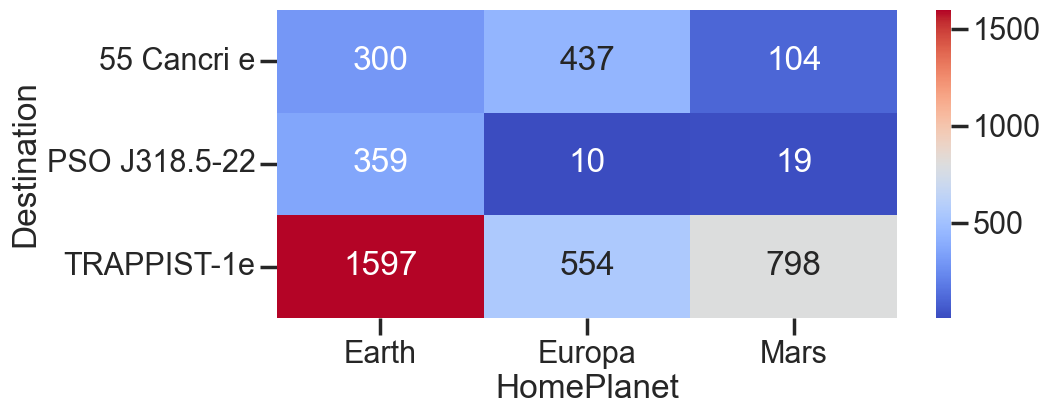

In [572]:
# Joint distribution of HomePlanet and Destination
sns.set_context("poster")
sns.set_style("ticks")
HPD_gb=test.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

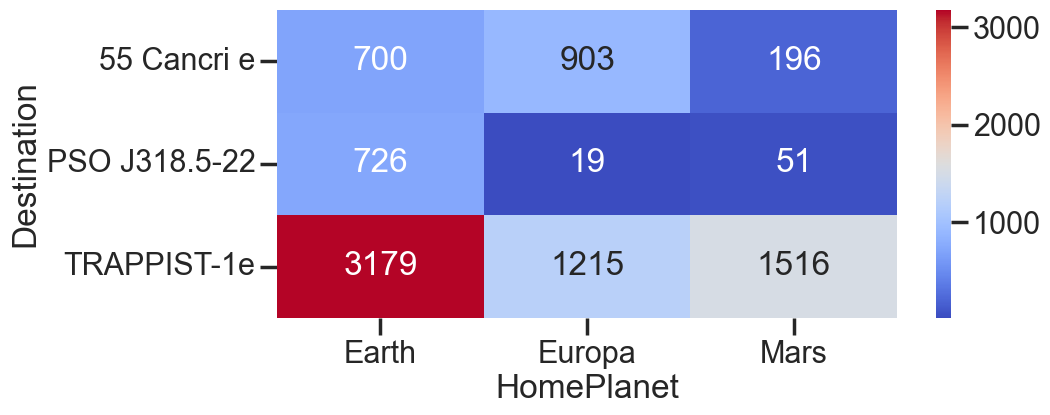

In [573]:
# Joint distribution of HomePlanet and Destination
sns.set_context("poster")
sns.set_style("ticks")
HPD_gb=train.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

In [574]:
train.isnull().sum()

HomePlanet        6
CryoSleep        98
Destination     182
Age             179
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    103
Spa             114
VRDeck          107
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

In [575]:
train.groupby("HomePlanet")["Deck"].value_counts()

HomePlanet  Deck
Earth       G       2559
            F       1647
            E        403
Europa      B        779
            C        747
            A        256
            D        192
            E        133
            T          5
Mars        F       1143
            E        339
            D        285
Name: count, dtype: int64

### Using the correlations observed in the heatmaps we are going to fill the null values in likelyhood of Destination based on Origin and viceversa, it's going to create a bias, but as long as the same bias is created in the way in the training and test data, it shouldn't affect our moder too much:

In [576]:
test.loc[(test['Destination'] == "PSO J318.5-22") & 
         (test['HomePlanet'].isna()) &
         (~test['Deck'].isin(["A", "B", "C", "T"])),'HomePlanet'] = "Earth"

test.loc[(test['HomePlanet'] == "Mars") & (test['Destination'].isna()),'Destination'] = "TRAPPIST-1e"
test.loc[(test['HomePlanet'] == "Earth") & (test['Destination'].isna()),'Destination'] = "TRAPPIST-1e"

test.loc[(test['Destination'] == "TRAPPIST-1e") & 
         (test['HomePlanet'].isna()) &
         (~test['Deck'].isin(["A", "B", "C", "T"])),'HomePlanet'] = "Earth"

test.loc[(test['HomePlanet'] == "Europa") & (test['Destination'].isna()),'Destination'] = "TRAPPIST-1e"
test.loc[(test['Destination'] == "55 Cancri e") & (test['HomePlanet'].isna()),'HomePlanet'] = "Europa"


train.loc[(train['Destination'] == "PSO J318.5-22") & 
         (train['HomePlanet'].isna()) &
         (~test['Deck'].isin(["A", "B", "C", "T"])),'HomePlanet'] = "Earth"

train.loc[(train['HomePlanet'] == "Mars") & (train['Destination'].isna()),'Destination'] = "TRAPPIST-1e"
train.loc[(train['HomePlanet'] == "Earth") & (train['Destination'].isna()),'Destination'] = "TRAPPIST-1e"

train.loc[(train['Destination'] == "TRAPPIST-1e") & 
         (train['HomePlanet'].isna()) &
         (~test['Deck'].isin(["A", "B", "C", "T"])),'HomePlanet'] = "Earth"

train.loc[(train['HomePlanet'] == "Europa") & (train['Destination'].isna()),'Destination'] = "TRAPPIST-1e"
train.loc[(train['Destination'] == "55 Cancri e") & (train['HomePlanet'].isna()),'HomePlanet'] = "Europa"

In [577]:
train.isnull().sum()

HomePlanet        3
CryoSleep        98
Destination       0
Age             179
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    103
Spa             114
VRDeck          107
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
dtype: int64

In [578]:
train.loc[(train['HomePlanet'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
2274,NaN,False,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,0.0,False,D,72.0,P,2443.0,1.0,nan,nan
4548,NaN,True,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,True,F,915.0,S,4840.0,1.0,nan,nan
5762,NaN,False,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,1.0,629.0,False,F,1166.0,S,6108.0,1.0,nan,nan


### Checking for other patterns... nothing too useful:

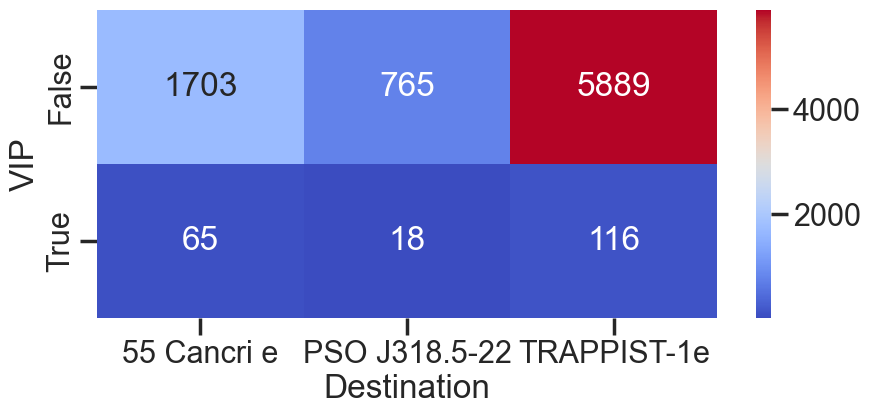

In [579]:
sns.set_context("poster")
sns.set_style("ticks")
HPD_gb=train.groupby(['Destination','VIP'])['VIP'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

<Axes: xlabel='HomePlanet', ylabel='Destination'>

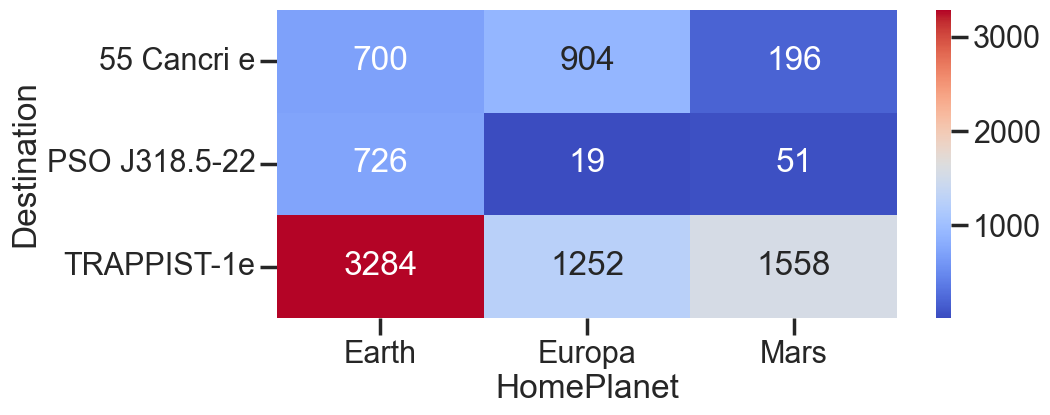

In [580]:
# Joint distribution of HomePlanet and Destination
sns.set_context("poster")
sns.set_style("ticks")
HPD_gb=train.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [581]:
train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1.0,1.0,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,2.0,1.0,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,3.0,1.0,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,3.0,2.0,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,4.0,1.0,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98.0,P,9276.0,1.0,Gravior,Noxnuther
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499.0,S,9278.0,1.0,Kurta,Mondalley
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500.0,S,9279.0,1.0,Fayey,Connon
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608.0,S,9280.0,1.0,Celeon,Hontichre


### Now let's check if we can extract some more information from the spending data, let's add the total spenditures, and see if we can use it for something:

In [582]:
train["Spent"] = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
test["Spent"] = test[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1.0,1.0,Maham,Ofracculy,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,2.0,1.0,Juanna,Vines,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,3.0,1.0,Altark,Susent,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,3.0,2.0,Solam,Susent,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,4.0,1.0,Willy,Santantines,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98.0,P,9276.0,1.0,Gravior,Noxnuther,8536.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499.0,S,9278.0,1.0,Kurta,Mondalley,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500.0,S,9279.0,1.0,Fayey,Connon,1873.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608.0,S,9280.0,1.0,Celeon,Hontichre,4637.0


### Looking at the distrubution, it seems that over 75% of people not in CryoSleep spent at least something in services, it would not a crazy to assume that the ones who didn't was because they we asleep:

In [583]:
train.groupby("CryoSleep")["Spent"].describe()

,count,mean,std,min,25%,50%,75%,max
CryoSleep,,,,,,,,
False,5558.0,2253.589601,3233.849139,0.0,748.25,1028.5,2427.75,35987.0
True,3037.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [584]:
train.loc[(train['CryoSleep'].isna())]["Spent"].describe()

count    98.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Spent, dtype: float64

### Okay, so let's just assume that we they didn't spend anything during the whole trip is because they were assleep:

In [585]:
test.loc[(test['Spent'] > 0) & (test['CryoSleep'].isna()),'CryoSleep'] = False
test.loc[(test['Spent'] == 0) & (test['CryoSleep'].isna()),'CryoSleep'] = True

train.loc[(train['Spent'] > 0) & (train['CryoSleep'].isna()),'CryoSleep'] = False
train.loc[(train['Spent'] == 0) & (train['CryoSleep'].isna()),'CryoSleep'] = True

In [586]:
train.isna().sum()

HomePlanet        3
CryoSleep         0
Destination       0
Age             179
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    103
Spa             114
VRDeck          107
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

In [587]:
test.loc[(train['CryoSleep'] == True) & (test['Spa'].isna()),'Spa'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['VRDeck'].isna()),'VRDeck'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['FoodCourt'].isna()),'FoodCourt'] = 0.0
test.loc[(train['CryoSleep'] == True) & (test['RoomService'].isna()),'RoomService'] = 0.0

train.loc[(train['CryoSleep'] == True) & (train['Spa'].isna()),'Spa'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['VRDeck'].isna()),'VRDeck'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['ShoppingMall'].isna()),'ShoppingMall'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['FoodCourt'].isna()),'FoodCourt'] = 0.0
train.loc[(train['CryoSleep'] == True) & (train['RoomService'].isna()),'RoomService'] = 0.0

train.isna().sum()

HomePlanet        3
CryoSleep         0
Destination       0
Age             179
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    101
Spa             113
VRDeck          105
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

### Now, we saw VIPs do not go into the Deck G, does that mean that the decks are divided by class? If so, we don't want to lose that information

In [588]:
train.loc[(train['CryoSleep'] == False)].groupby("Deck")[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Spent"]].mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spent
Deck,,,,,,,
A,36.386740,187.131868,2133.156757,158.292135,959.308108,1293.169399,4708.054054
B,35.240580,188.367816,2772.514368,337.604651,1617.938953,1650.537143,6497.954416
C,35.747100,307.108545,3107.186047,294.910138,1561.944573,1833.096998,6954.902494
D,33.421196,869.115702,757.485014,398.956284,608.500000,369.807692,2941.911290
E,29.497804,390.498547,333.490593,287.278261,340.051245,302.533430,1625.321429
F,28.721842,387.652433,182.851103,300.541322,206.897706,183.091996,1234.089438
G,25.289956,159.942257,175.261404,153.733913,197.179667,166.388307,836.251286
T,37.000000,427.200000,1397.400000,0.500000,2008.400000,883.000000,4716.400000


In [589]:
train.loc[(train['CryoSleep'] == False)].groupby("VIP")[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Spent"]].mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spent
VIP,,,,,,,
False,29.373603,341.131879,668.936137,271.507998,474.551924,443.703282,2157.319955
True,37.604520,530.775862,2020.803468,277.797688,846.666667,1375.982857,4947.584270


### Okay it clearly does, but if want to preserve that information we need to write a script with lots of conditions, meaning loooong:

In [590]:
decks = ["A", "B", "C", "D", "E", "F", "G", "T"]

for deck in decks:
    median_age = test.loc[(test['VIP'] == False) & (test['Deck'] == deck), 'Age'].median()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['Age'].isna()), 'Age'] = median_age

for deck in decks:
    median_age = test.loc[(test['VIP'] == True) & (test['Deck'] == deck), 'Age'].median()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['Age'].isna()), 'Age'] = median_age

In [591]:
for deck in decks:
    median_age = train.loc[(train['VIP'] == False) & (train['Deck'] == deck), 'Age'].median()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['Age'].isna()), 'Age'] = median_age

for deck in decks:
    median_age = train.loc[(train['VIP'] == True) & (train['Deck'] == deck), 'Age'].median()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['Age'].isna()), 'Age'] = median_age

In [592]:
train.isna().sum()

HomePlanet        3
CryoSleep         0
Destination       0
Age               8
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    101
Spa             113
VRDeck          105
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

In [593]:
train.loc[(train["Age"].isna()),'Age'] = train["Age"].median()
test.loc[(test["Age"].isna()),'Age'] = test["Age"].median()

In [594]:
train.isna().sum()

HomePlanet        3
CryoSleep         0
Destination       0
Age               0
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    101
Spa             113
VRDeck          105
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

In [595]:
train.loc[(train['Age'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent


In [596]:
train["Spa"]

0          0.0
1        549.0
2       6715.0
3       3329.0
4        565.0
         ...  
8688    1643.0
8689       0.0
8690       1.0
8691     353.0
8692       0.0
Name: Spa, Length: 8693, dtype: float64

In [597]:
for deck in decks:
    mean_spa = test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'Spa'].mean()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['Spa'].isna()), 'Spa'] = mean_spa

for deck in decks:
    mean_spa = test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'Spa'].mean()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['Spa'].isna()), 'Spa'] = mean_spa

In [598]:
for deck in decks:
    mean_spa = train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'Spa'].mean()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['Spa'].isna()), 'Spa'] = mean_spa


for deck in decks:
    mean_spa = train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'Spa'].mean()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['Spa'].isna()), 'Spa'] = mean_spa

In [599]:
train.loc[(train['Spa'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent
2591,Mars,False,TRAPPIST-1e,35.0,NaN,2301.0,0.0,414.0,NaN,0.0,True,D,82.0,P,2778.0,1.0,Gorice,Fisty,2715.0
2762,Earth,False,TRAPPIST-1e,27.0,False,740.0,82.0,6.0,NaN,1.0,False,NaN,NaN,NaN,2970.0,1.0,Dwin,Adkinson,829.0


In [600]:
train.loc[(train["Spa"].isna()),'Spa'] = train.loc[
    (train["CryoSleep"] == False)]["Spa"].mean()

test.loc[(test["Spa"].isna()),'Spa'] = test.loc[
    (test["CryoSleep"] == False)]["Spa"].mean()

In [601]:
train.isna().sum()

HomePlanet        3
CryoSleep         0
Destination       0
Age               0
VIP             137
RoomService     107
FoodCourt       106
ShoppingMall    101
Spa               0
VRDeck          105
Transported       0
Deck            199
Num             199
Side            199
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

In [602]:
for deck in decks:
    mean_room = test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'RoomService'].mean()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['RoomService'].isna()), 'RoomService'] = mean_room

for deck in decks:
    mean_room = test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'RoomService'].mean()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['RoomService'].isna()), 'RoomService'] = mean_room

In [603]:
for deck in decks:
    mean_room = train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'RoomService'].mean()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['RoomService'].isna()), 'RoomService'] = mean_room


for deck in decks:
    mean_room = train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'RoomService'].mean()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['RoomService'].isna()), 'RoomService'] = mean_room

In [604]:
train.loc[(train['RoomService'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent
280,Europa,False,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,4476.0,241.0,False,NaN,NaN,NaN,310.0,1.0,Naviton,Coudered,4947.0
7797,Europa,False,PSO J318.5-22,45.0,True,NaN,49.0,0.0,4864.0,3902.0,False,NaN,NaN,NaN,8322.0,1.0,Hamelik,Briouse,8815.0


In [605]:
train.loc[(train["RoomService"].isna()),'RoomService'] = train.loc[
    (train["CryoSleep"] == False)]["RoomService"].mean()

test.loc[(test["RoomService"].isna()),'RoomService'] = test.loc[
    (test["CryoSleep"] == False)]["RoomService"].mean()

In [606]:
for deck in decks:
    mean_food = test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'FoodCourt'].mean()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['FoodCourt'].isna()), 'FoodCourt'] = mean_food

for deck in decks:
    mean_food = test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'FoodCourt'].mean()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['FoodCourt'].isna()), 'FoodCourt'] = mean_food

In [607]:
for deck in decks:
    mean_food = train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'FoodCourt'].mean()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['FoodCourt'].isna()), 'FoodCourt'] = mean_food


for deck in decks:
    mean_food = train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'FoodCourt'].mean()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['FoodCourt'].isna()), 'FoodCourt'] = mean_food

In [608]:
train.loc[(train['FoodCourt'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent
1559,Earth,False,TRAPPIST-1e,28.0,False,3202.0,NaN,0.0,0.0,5.0,False,NaN,NaN,NaN,1655.0,1.0,Karay,Dicksons,3207.0
1681,Earth,False,TRAPPIST-1e,40.0,NaN,596.0,NaN,135.0,73.0,0.0,False,F,341.0,S,1782.0,2.0,Carold,Moodson,804.0
5908,Earth,False,TRAPPIST-1e,20.0,False,379.0,NaN,29.0,39.0,91.0,False,NaN,NaN,NaN,6265.0,1.0,Natald,Puckenton,538.0
6112,Mars,False,TRAPPIST-1e,37.0,False,610.0,NaN,410.0,148.0,14.0,False,NaN,NaN,NaN,6451.0,1.0,Carkes,Panad,1182.0
6325,Europa,False,TRAPPIST-1e,30.0,NaN,0.0,NaN,335.0,143.0,764.0,True,C,210.0,P,6684.0,2.0,Ziba,Exhaft,1242.0


In [609]:
train.loc[(train["FoodCourt"].isna()),'FoodCourt'] = train.loc[(train["CryoSleep"] == False)]["FoodCourt"].mean()
test.loc[(test["FoodCourt"].isna()),'FoodCourt'] = test.loc[(test["CryoSleep"] == False)]["FoodCourt"].mean()

In [610]:
for deck in decks:
    mean_mall = test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'ShoppingMall'].mean()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['ShoppingMall'].isna()), 'ShoppingMall'] = mean_mall

for deck in decks:
    mean_mall = test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'ShoppingMall'].mean()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['ShoppingMall'].isna()), 'ShoppingMall'] = mean_mall

In [611]:
for deck in decks:
    mean_mall = train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'ShoppingMall'].mean()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['ShoppingMall'].isna()), 'ShoppingMall'] = mean_mall


for deck in decks:
    mean_mall = train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'ShoppingMall'].mean()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['ShoppingMall'].isna()), 'ShoppingMall'] = mean_mall

In [612]:
train.loc[(train['ShoppingMall'].isna())]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,ID1,ID2,1stName,Surname,Spent
5409,Earth,False,PSO J318.5-22,46.0,NaN,559.0,25.0,NaN,22.0,765.0,False,F,1199.0,P,5777.0,1.0,Katen,River,1371.0
6067,Europa,False,TRAPPIST-1e,65.0,NaN,0.0,1420.0,NaN,85.0,827.0,False,A,77.0,S,6413.0,1.0,Grasath,Undrude,2332.0
6488,Earth,False,TRAPPIST-1e,22.0,NaN,735.0,138.0,NaN,0.0,0.0,False,F,1424.0,P,6850.0,1.0,Adamy,Wolferton,873.0


In [613]:
train.loc[(train["ShoppingMall"].isna()),'ShoppingMall'] = train.loc[(train["CryoSleep"] == False)]["ShoppingMall"].mean()
test.loc[(test["ShoppingMall"].isna()),'ShoppingMall'] = test.loc[(test["CryoSleep"] == False)]["ShoppingMall"].mean()

In [614]:
for deck in decks:
    mean_vr = test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'VRDeck'].mean()
    test.loc[(test['VIP'] == False) & (test['Deck'] == deck) & (test['VRDeck'].isna()), 'VRDeck'] = mean_vr

for deck in decks:
    mean_vr = test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['CryoSleep'] == False), 'VRDeck'].mean()
    test.loc[(test['VIP'] == True) & (test['Deck'] == deck) & (test['VRDeck'].isna()), 'VRDeck'] = mean_vr

In [615]:
for deck in decks:
    mean_vr = train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'VRDeck'].mean()
    train.loc[(train['VIP'] == False) & (train['Deck'] == deck) & (train['VRDeck'].isna()), 'VRDeck'] = mean_vr


for deck in decks:
    mean_vr = train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['CryoSleep'] == False), 'VRDeck'].mean()
    train.loc[(train['VIP'] == True) & (train['Deck'] == deck) & (train['VRDeck'].isna()), 'VRDeck'] = mean_vr

In [616]:
train.loc[(train["VRDeck"].isna()),'VRDeck'] = train.loc[(train["CryoSleep"] == False)]["VRDeck"].mean()
test.loc[(test["VRDeck"].isna()),'VRDeck'] = test.loc[(train["CryoSleep"] == False)]["VRDeck"].mean()

### Recalculate the Spent column:

In [617]:
train["Spent"] = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
test["Spent"] = test[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

### Check with everything makes sense still:

In [618]:
train.groupby("CryoSleep")["Spent"].describe()

,count,mean,std,min,25%,50%,75%,max
CryoSleep,,,,,,,,
False,5558.0,2292.697899,3246.856817,0.0,768.25,1057.0,2465.25,35987.0
True,3135.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [619]:
train.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,215.757951,421.367478,171.645181,299.468042,279.435691
True,472.923444,1791.568874,246.388690,757.380025,1221.599851


In [620]:
train.groupby("VIP")[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,,
False,28.527941,215.757951,421.367478,171.645181,299.468042,279.435691
True,37.417085,472.923444,1791.568874,246.388690,757.380025,1221.599851


In [621]:
train.groupby("CryoSleep")[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,,
False,164641.0,1.950665e+06,3.960858e+06,1.501459e+06,2.697881e+06,2.631952e+06
True,85530.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [622]:
train.groupby("Deck")[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Deck,,,,,,
A,35.085938,135.024699,1541.539062,114.542421,693.250000,933.633076
B,33.595635,84.916146,1248.837347,152.097704,728.752809,744.296534
C,34.840696,180.970811,1831.243444,174.068980,921.996349,1081.444030
D,33.451883,676.384322,589.673957,310.213252,473.866674,287.668637
E,29.998858,311.941731,266.514814,229.537678,271.632983,241.888232
F,28.378311,308.631531,145.690591,239.382562,164.727662,145.748957
G,24.016022,72.877168,79.857287,70.048356,89.844272,75.814289
T,37.000000,427.200000,1397.400000,0.500000,2008.400000,883.000000


### Finally, we got rid of most of the null values:

In [623]:
test.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP              70
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Deck            100
Num             100
Side            100
ID1               0
ID2               0
1stName           0
Surname           0
Spent             0
dtype: int64

### Trying to understand what happened based on the correlation matrix.

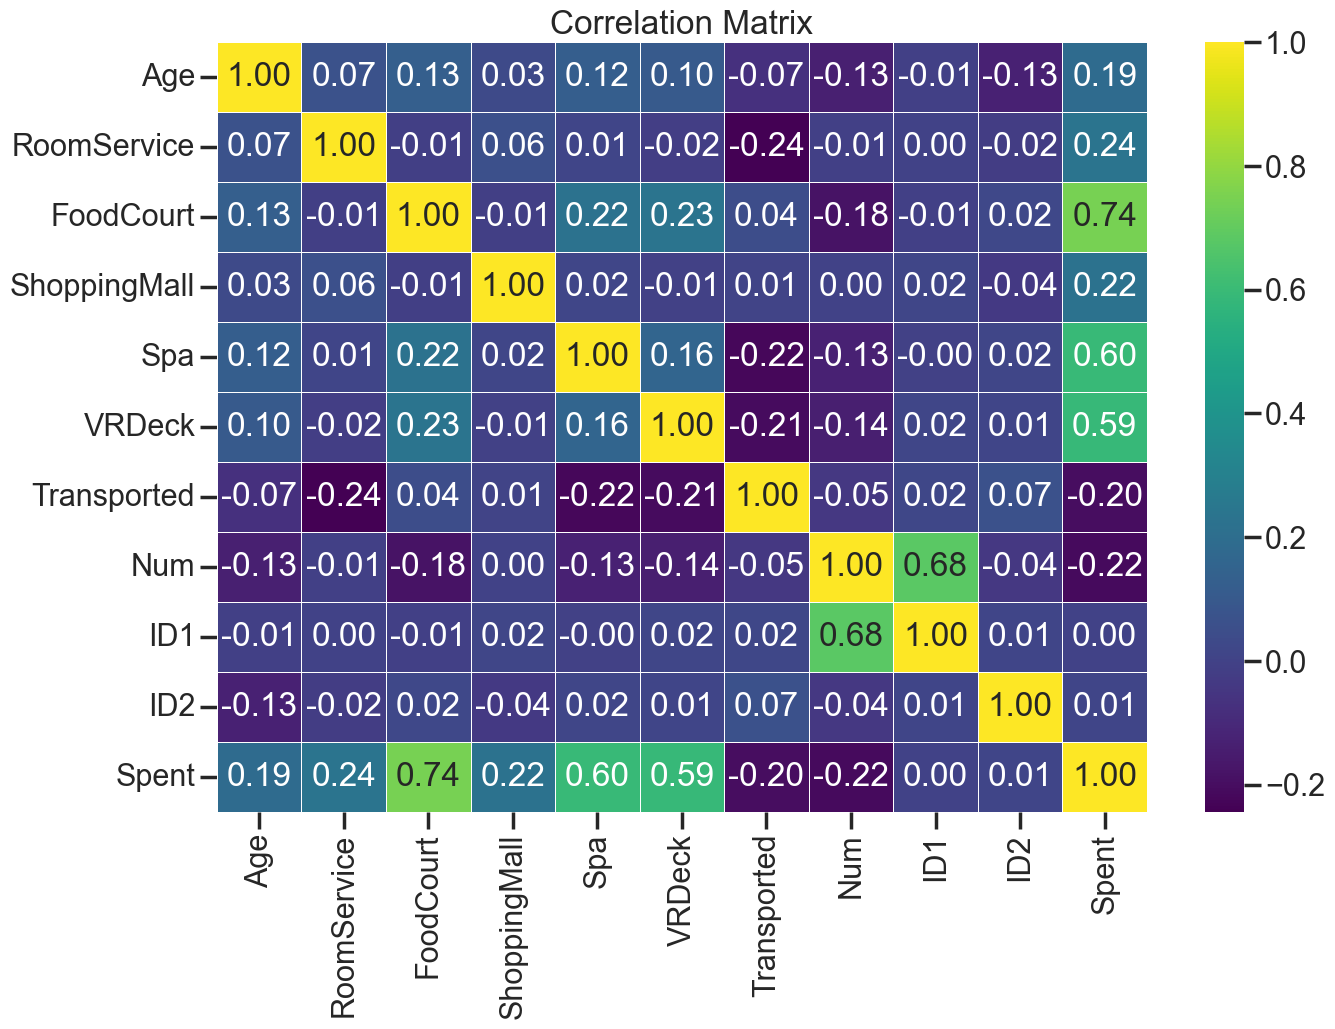

In [624]:
numeric_and_bool_cols = train.select_dtypes(include=['number', 'bool'])

corr_matrix = numeric_and_bool_cols.corr()

plt.figure(figsize=(15, 10))  # Set the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Seems that people that spend the most in RoomService, Spa and VRDeck were the least likely to get transported, but the accident happened in the other side of the ship?

###  Okay, I think I did everything I could here, let's prepare the data for machine learning, first drop the columns that are unlikely to be useful:

In [625]:
test = test.drop(["1stName", "Surname", "Deck", "Num", "Side", "VIP"], axis=1, errors='ignore')
train = train.drop(["1stName", "Surname", "Deck", "Num", "Side", "VIP"], axis=1, errors='ignore')

In [626]:
test.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
ID1             0
ID2             0
Spent           0
dtype: int64

### Get the text/categorical columns:

In [627]:
pd.options.mode.chained_assignment = None  # default='warn'
train["ID2"] = train["ID2"].astype("str", errors = "ignore")
categorical_cols = [cname for cname in train.columns if train[cname].dtype == "object"]
categorical_cols

['HomePlanet', 'CryoSleep', 'Destination', 'ID2']

### Convert them into 1s and 0s:

In [628]:
for col in categorical_cols:
    one_hot = pd.get_dummies(test[col])
    one_hot.columns = one_hot.columns.map(lambda x: str(x) + "_" + col)
    test = test.drop(col,axis = 1)
    test = test.join(one_hot)

for col in categorical_cols:
    one_hot = pd.get_dummies(train[col])
    one_hot.columns = one_hot.columns.map(lambda x: str(x) + "_" + col)
    train = train.drop(col,axis = 1)
    train = train.join(one_hot)
train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ID1,Spent,Earth_HomePlanet,...,PSO J318.5-22_Destination,TRAPPIST-1e_Destination,1.0_ID2,2.0_ID2,3.0_ID2,4.0_ID2,5.0_ID2,6.0_ID2,7.0_ID2,8.0_ID2
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1.0,0.0,False,...,False,True,True,False,False,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,2.0,736.0,True,...,False,True,True,False,False,False,False,False,False,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,3.0,10383.0,False,...,False,True,True,False,False,False,False,False,False,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,3.0,5176.0,False,...,False,True,False,True,False,False,False,False,False,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True,4.0,1091.0,True,...,False,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,9276.0,8536.0,False,...,False,False,True,False,False,False,False,False,False,False
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,9278.0,0.0,True,...,True,False,True,False,False,False,False,False,False,False
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,9279.0,1873.0,True,...,False,True,True,False,False,False,False,False,False,False
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,9280.0,4637.0,False,...,False,False,True,False,False,False,False,False,False,False


### Check the columns we created, to make sure that it makes sense:

In [629]:
test.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'ID1', 'Spent', 'Earth_HomePlanet', 'Europa_HomePlanet',
       'Mars_HomePlanet', 'False_CryoSleep', 'True_CryoSleep',
       '55 Cancri e_Destination', 'PSO J318.5-22_Destination',
       'TRAPPIST-1e_Destination', '1.0_ID2', '2.0_ID2', '3.0_ID2', '4.0_ID2',
       '5.0_ID2', '6.0_ID2', '7.0_ID2', '8.0_ID2'],
      dtype='object')

### Get the numerical columns:

In [630]:
numerical_cols = [cname for cname in train.columns if train[cname].dtype == "float64"]
numerical_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'ID1',
 'Spent']

### Normalize them:

In [631]:
ct = StandardScaler()
train[numerical_cols] = ct.fit_transform(train[numerical_cols])
test[numerical_cols] = ct.transform(test[numerical_cols])
train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ID1,Spent,Earth_HomePlanet,...,PSO J318.5-22_Destination,TRAPPIST-1e_Destination,1.0_ID2,2.0_ID2,3.0_ID2,4.0_ID2,5.0_ID2,6.0_ID2,7.0_ID2,8.0_ID2
0,0.712083,-0.339735,-0.285086,-0.288903,-0.275551,-0.266812,False,-1.734409,-0.519857,False,...,False,True,True,False,False,False,False,False,False,False
1,-0.332889,-0.174708,-0.279454,-0.247086,0.211889,-0.228037,True,-1.734034,-0.258841,True,...,False,True,True,False,False,False,False,False,False,False
2,2.035715,-0.274633,1.952364,-0.288903,5.686480,-0.223631,False,-1.733660,3.162372,False,...,False,True,True,False,False,False,False,False,False,False
3,0.294094,-0.339735,0.517668,0.331654,2.680160,-0.096732,False,-1.733660,1.315761,False,...,False,True,False,True,False,False,False,False,False,False
4,-0.890208,0.119008,-0.241288,-0.036331,0.226095,-0.265049,True,-1.733286,-0.132944,True,...,False,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.851413,-0.339735,3.981461,-0.288903,1.183216,-0.201600,False,1.738236,2.507352,False,...,False,False,True,False,False,False,False,False,False,False
8689,-0.750878,-0.339735,-0.285086,-0.288903,-0.275551,-0.266812,False,1.738984,-0.519857,True,...,True,False,True,False,False,False,False,False,False,False
8690,-0.193560,-0.339735,-0.285086,2.842318,-0.274663,-0.266812,True,1.739359,0.144384,True,...,False,True,True,False,False,False,False,False,False,False
8691,0.224429,-0.339735,0.371258,-0.288903,0.037867,2.584018,False,1.739733,1.124610,False,...,False,False,True,False,False,False,False,False,False,False


### Separate the columns of interest from the labels, so that we can train the data

In [632]:
data = train.drop(["Transported"], axis=1, errors='ignore')
labels = train["Transported"]

In [633]:
x_train, x_valid, y_train, y_valid = train_test_split(data,labels,stratify=labels,train_size=0.8,test_size=0.2,random_state=0)

### Try a bunch of configurations to find an optimal solution, but only show the final result for the reader:

In [634]:
knn =  KNeighborsClassifier(n_neighbors=100)

In [635]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [636]:
y_estimate = knn.predict(x_valid)

In [637]:
print(classification_report(y_valid, y_estimate))

              precision    recall  f1-score   support

       False       0.75      0.82      0.78       863
        True       0.80      0.74      0.77       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



### Try another machine learning model to get better results:

In [638]:
rf = RandomForestClassifier(n_estimators=500)

In [639]:
rf.fit(x_train, y_train)
y_forest = rf.predict(x_valid)

In [640]:
print(classification_report(y_valid, y_forest))

              precision    recall  f1-score   support

       False       0.78      0.81      0.79       863
        True       0.80      0.77      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



### Look at the parameters to see what is the most relevant to sort the data, weirdly it's our custom columns that have more predictive ability. 

### It seems that ID1 is the most useful, maybe because people with ID numbers close to each other got the same fate.

<Axes: >

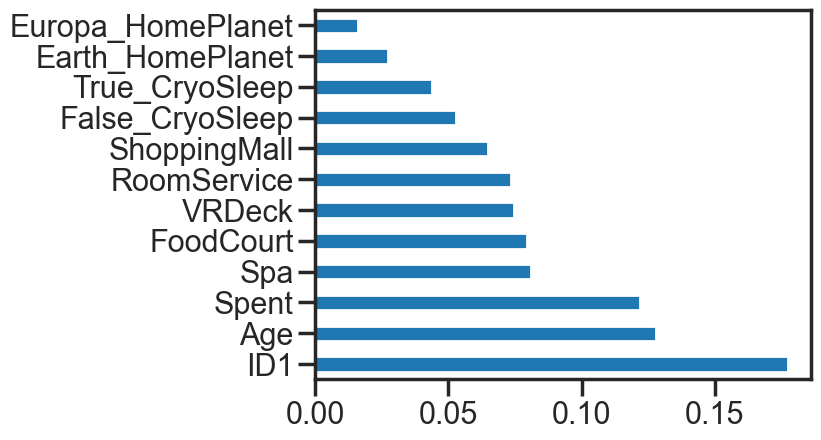

In [641]:
feat_importances = pd.Series(rf.feature_importances_, index=data.columns)
feat_importances.nlargest(12).plot(kind='barh')

### We can check again for positive and negative correlations, trying to understand which way it will tilt the prediction again, people that spent less time in the Spa, VRDeck and in the room where less likely to get transported, all factors with significant weight.

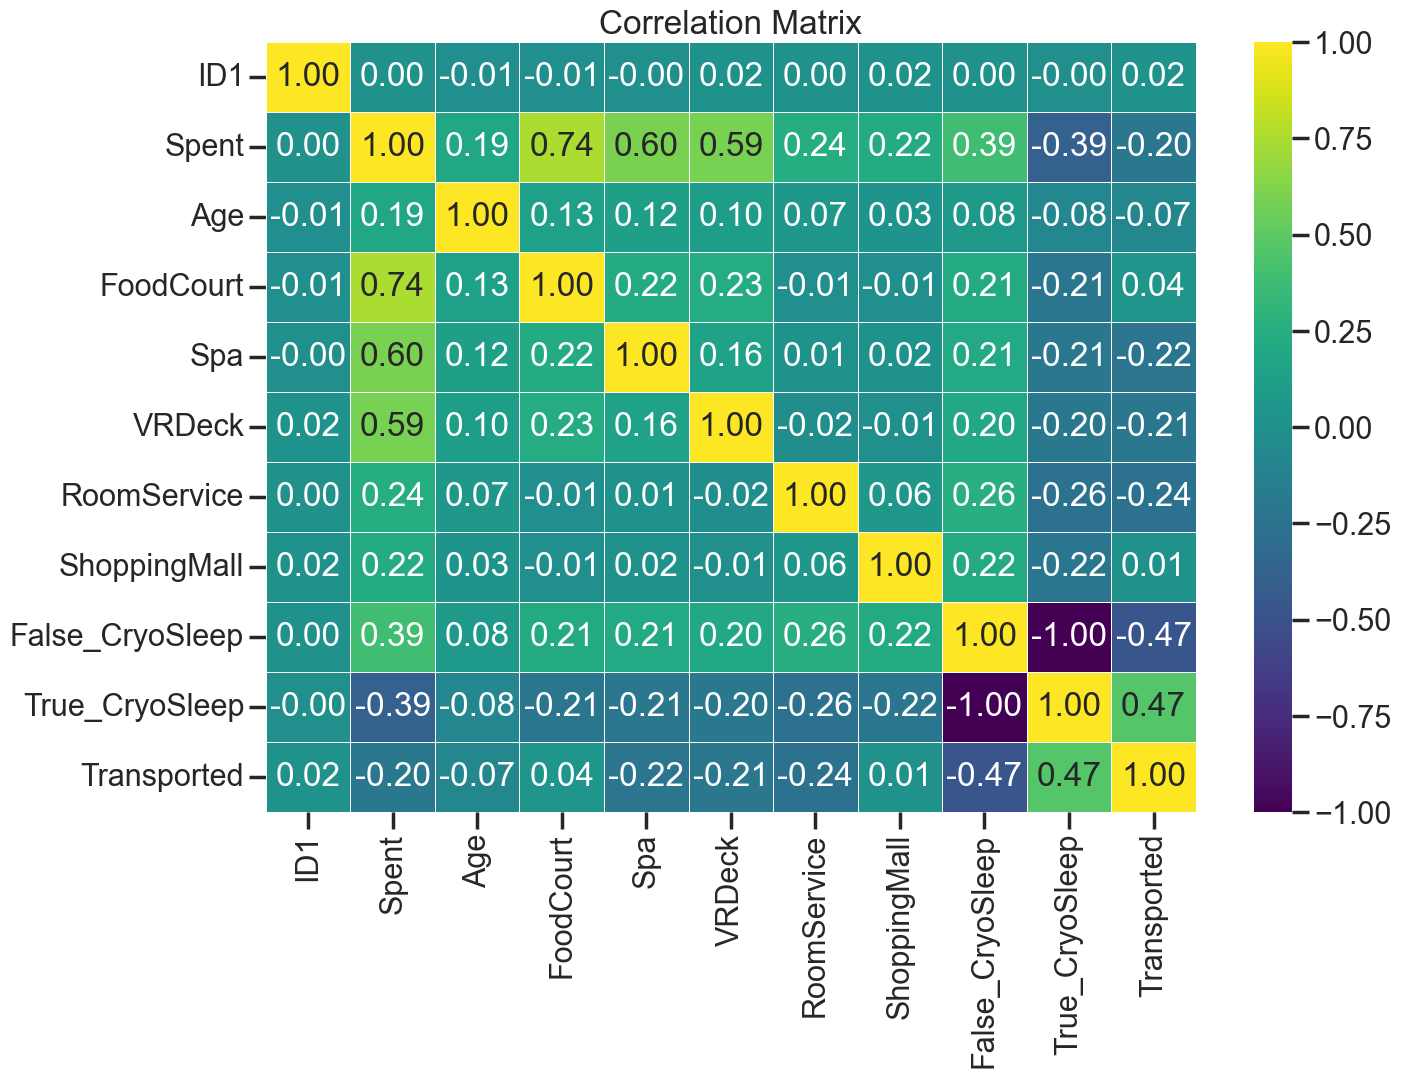

In [654]:
corr_matrix = train[["ID1",
                     "Spent",
                     "Age",
                     "FoodCourt", 
                     "Spa", 
                     "VRDeck", 
                     "RoomService", 
                     "ShoppingMall",
                     "False_CryoSleep", 
                     "True_CryoSleep",
                     "Transported"]].corr()

plt.figure(figsize=(15, 10)) 
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [643]:
rf.fit(data, labels)
prediction = rf.predict(test)

### Now this is a damn competion, so let's bring out the big guns, neural networks:

In [644]:
model = Sequential()

In [645]:
model.add(tf.keras.layers.InputLayer(input_shape=(len(data.columns),)))

c:\Users\Helios\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



### It seems that a brain with too many neurons memorises the data (overfitting), actually a simpler one gives me better predictive ability because it can detect general patterns:

In [646]:
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [647]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [648]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

In [649]:
model.fit(x_train, y_train, epochs = 30, batch_size = 10)

Epoch 1/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - binary_accuracy: 0.6182 - false_negatives: 827.2137 - loss: 0.6749
Epoch 2/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - binary_accuracy: 0.7286 - false_negatives: 335.6255 - loss: 0.6301
Epoch 3/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - binary_accuracy: 0.7627 - false_negatives: 388.7633 - loss: 0.5855
Epoch 4/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - binary_accuracy: 0.7626 - false_negatives: 440.8795 - loss: 0.5474
Epoch 5/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - binary_accuracy: 0.7760 - false_negatives: 419.0732 - loss: 0.5020
Epoch 6/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - binary_accuracy: 0.7809 - false_negatives: 433.1019 - loss: 0.4804
Epoch 7/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - binary_accuracy: 0.7794 - false_negatives: 423.9957 - loss: 0.4649
Epoch 8/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 0.7754 - false_negatives: 427.8092 - loss: 0.4656
Epoch 9/30
696/6

In [650]:
y_brain = model.predict(x_valid)
y_brain = [1 if x > 0.5 else 0 for x in y_brain]
print(classification_report(y_valid, y_brain))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       863
           1       0.78      0.82      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [651]:
prediction = model.predict(test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


### Change everything to False and True, since the result from the neural network is 1s and 0s

In [652]:
prediction = [1 if x > 0.5 else 0 for x in prediction]
for i in range(len(prediction)):
    prediction[i] = bool(prediction[i])
prediction[:5]

[True, False, True, True, False]

### Store the data and submit to Kaggle:

In [656]:
# Sample submission (to get right format)
sub=pd.read_csv("https://raw.githubusercontent.com/Herrikez/Machine-Learning/main/sample_submission.csv")

# Add predictions
sub['Transported']=prediction

sub.to_csv('submission.csv', index=False)